![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [6]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [7]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [9]:
# Celda 1


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [11]:
import numpy as np

In [12]:
# Celda 2

# Bagging manual

# Paso 1: hacer muestras con bootstrap para cada arbol, del mismo tamaño de observaciones que en train
observaciones_por_muestra = X_train.shape[0]
cantidad_de_muestras = 10 # 10 arboles

# list comprehension para crear las 10 muestras
np.random.seed(123)
muestras = [np.random.choice(a=observaciones_por_muestra, size=observaciones_por_muestra, replace=True) for muestra in range(cantidad_de_muestras)]

for i in range(len(muestras)):
    print(f"Muestra {i} de tamaño {len(muestras[i])}: ")
    print(muestras[i])

Muestra 0 de tamaño 7031: 
[3582 3454 1346 ...  826  801 5657]
Muestra 1 de tamaño 7031: 
[6962 3408 2553 ... 6611  877 6412]
Muestra 2 de tamaño 7031: 
[1917 3131  384 ... 2876 6449 6557]
Muestra 3 de tamaño 7031: 
[3849 4565 6820 ... 6835 4643  639]
Muestra 4 de tamaño 7031: 
[2468 3608 1367 ... 3108 2961 4357]
Muestra 5 de tamaño 7031: 
[3142 1537 5966 ... 3224 6922 3396]
Muestra 6 de tamaño 7031: 
[6588 3753 1786 ... 2131 4627 5672]
Muestra 7 de tamaño 7031: 
[1289 3776  981 ... 1891 6034 6165]
Muestra 8 de tamaño 7031: 
[6079 3819 6976 ... 6478 2225 5072]
Muestra 9 de tamaño 7031: 
[3952 3276  896 ... 4589 1964  893]


In [13]:
# Paso 2 crear los arboles con las diferentes muestras creadas en el paso anterior
from sklearn.tree import DecisionTreeRegressor

# definicion del objeto de decision tree reg
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# dataframe para guardar las predicciones (columnas = cantidad de arboles, filas = los indices de las observaciones en test)
y_pred_bag_manual = pd.DataFrame(index=X_test.index, columns=list(range(cantidad_de_muestras)))

y_pred_bag_manual.head()

,0,1,2,3,4,5,6,7,8,9
257343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
for i, sample in enumerate(muestras):
    # seleccionar por posicion (iloc) las observaciones en X_train
    xtrain = X_train.iloc[sample, :]
    ytrain = y_train.iloc[sample]
    treereg.fit(xtrain, ytrain)
    y_pred_bag_manual.iloc[:,i] = treereg.predict(X_test)

y_pred_bag_manual

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [19]:
# desempeño de cada arbol
from sklearn.metrics import mean_squared_error

errores_bag_manual = []
for i in range(cantidad_de_muestras):
    error = np.sqrt(mean_squared_error(y_pred_bag_manual.iloc[:,i], y_test))
    errores_bag_manual.append(error)
    print(f"Arbol {i} tiene un error: {error}")

Arbol 0 tiene un error: 2141.613353645869
Arbol 1 tiene un error: 2136.3519863123465
Arbol 2 tiene un error: 2122.718759132052
Arbol 3 tiene un error: 2087.278992468617
Arbol 4 tiene un error: 2168.518742842026
Arbol 5 tiene un error: 2113.8811455834793
Arbol 6 tiene un error: 2127.933470769012
Arbol 7 tiene un error: 2184.414847251443
Arbol 8 tiene un error: 2138.1071697514985
Arbol 9 tiene un error: 2132.097520859104


In [20]:
# Paso 3: agregar las predicciones de los arboles 

# agregar una columna que promedie las demas columnas para obtener la prediccion del bagging
y_pred_bag_manual['final'] = y_pred_bag_manual.mean(axis=1)
y_pred_bag_manual.head()

,0,1,2,3,4,5,6,7,8,9,final
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0,13767.4
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0,6243.1
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0,16694.3
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0,20865.3
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0,16468.1


In [40]:
# medir el desempeño
error_bag_manual = np.sqrt(mean_squared_error(y_pred_bag_manual['final'],y_test))

errores_bag_manual.append(error_bag_manual)

print(f"Error al promediar todos los arboles {error_bag_manual} ")

Error al promediar todos los arboles 1796.4355868399332 


Text(0.5, 1.0, 'Errores de Arboles + Final = Bagging')

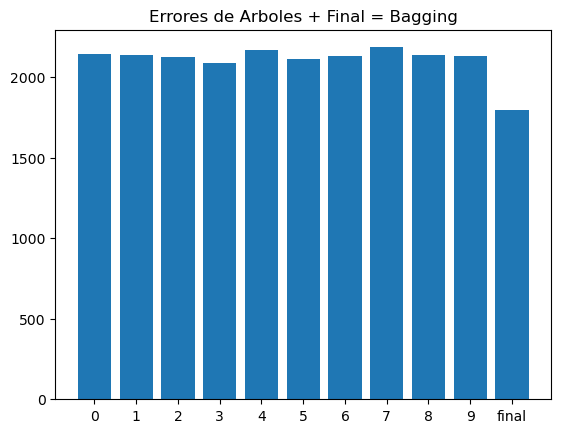

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

ax.bar(x=y_pred_bag_manual.columns.astype(str), height=errores_bag_manual) 
ax.set_title("Errores de Arboles + Final = Bagging")

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [43]:
# Celda 3
from sklearn.ensemble import BaggingRegressor

n_features = X_train.shape[1]
max_features = int(np.log(n_features))  # logaritmo natural

bagreg = BaggingRegressor(DecisionTreeRegressor(max_features=max_features), n_estimators=10, bootstrap=True, oob_score=True, random_state=1)
bagreg.fit(X_train, y_train)
y_pred_bag_libreria = bagreg.predict(X_test)
y_pred_bag_libreria

array([13311.4,  6774.8, 16692.6, ..., 22596.4, 12990.6, 11965. ])

In [44]:
# medir el desempeño
error_bag_libreria = np.sqrt(mean_squared_error(y_pred_bag_libreria, y_test))
print(f"El error de Bagging con libreria sklearn es {error_bag_libreria}")

El error de Bagging con libreria sklearn es 1824.292388455352


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [46]:
# Celda 4


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [48]:
# Celda 5


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [50]:
# Celda 6


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [52]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [54]:
# Celda 8
